In [15]:
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder # 【追加】 画像データセットを提供するモジュール
from torchvision import models # 【追加】 事前学習済みモデルや一般的なモデルアーキテクチャを含むモジュール

In [16]:
# (2-D) データの前処理
data_transforms = {
    'train': transforms.Compose([ 
        transforms.Resize((224, 224)), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(10), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNetデータセットの平均と標準偏差を使用

    ]),
    'val': transforms.Compose([ 
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNetデータセットの平均と標準偏差を使用、検証データに対しても同様に正規化を行う。理由は、学習時と同じ前処理を行うことで、モデルの性能を正確に評価するため。
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNetの平均と標準偏差を使用
    ]),
}

In [17]:
full_dataset = ImageFolder(root='EuroSAT_RGB')

# データセットを70%訓練、15%検証、15%テストに分割
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# 各データセットに適切な変換を適用するためのラッパークラスを定義
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset  # Subsetオブジェクト
        self.transform = transform  # 適用する変換

    def __getitem__(self, index):
        image, label = self.subset[index]  # 画像とラベルを取得
        if self.transform:
            image = self.transform(image)  # 変換を適用
        return image, label

    def __len__(self):
        return len(self.subset)
    
# それぞれのデータセットに対応する変換を適用（ここで初めてデータを前処理する）
train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
val_dataset = CustomDataset(val_dataset, transform=data_transforms['val'])
test_dataset = CustomDataset(test_dataset, transform=data_transforms['val'])

In [18]:
BATCH_SIZE = 64  # ミニバッチサイズを設定、データセットのサイズによって自分で設定する
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
# ハードウェアの設定 
device = torch.device('mps')

ミニバッチサイズ:  torch.Size([64, 3, 224, 224])
画像のチャネル数:  3
画像の高さ:  224
画像の幅:  224


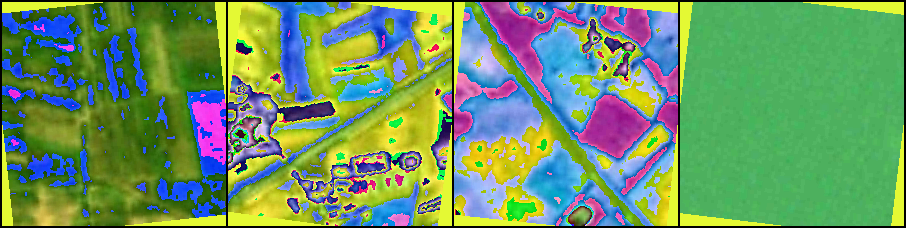

tensor([6, 3, 3, 9])


In [20]:
# ニューラルネットワークに入力する画像のサイズ、チャネル数をチェック
images, labels = next(iter(train_loader))
c, h, w = images[0].shape
print("ミニバッチサイズ: ", images.size())
print("画像のチャネル数: ", c)
print("画像の高さ: ", h)
print("画像の幅: ", w)

# グリッド乗に4枚の画像を表示
img = torchvision.utils.make_grid(images[:4])
img = transforms.functional.to_pil_image(img)
display(img)

# 上の画像に対応するラベルを表示
print(labels[:4])


In [21]:
# ニューラルネットワークに入力する画像のサイズと分類するクラス数を定義
INPUT_CHANNELS = c
OUTPUT_SIZE = 10  # 分類するクラス数

# ViT-Base-16モデルを読み込む
model = torchvision.models.vit_b_16(weights="IMAGENET1K_V1")

# パラメータを固定
for param in model.parameters():
    param.requires_grad = False

# 最終層を入れ替える
model.heads[0] = nn.Linear(model.heads[0].in_features, OUTPUT_SIZE)

# 最終層のパラメータのみ更新
for param in model.heads.parameters():
    param.requires_grad = True

# モデルをデバイスに転送
model = model.to(device)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
from tqdm import tqdm  # tqdmをインポート

# モデルの学習
EPOCHS = 3
train_loss_list = []  # 訓練データの損失リスト
val_loss_list = []    # 検証データの損失リスト
train_acc_list = []   # 訓練データの精度リスト
val_acc_list = []     # 検証データの精度リスト

for epoch in range(EPOCHS):
    model.train()  # モデルを学習モードに設定
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # 訓練データのループにtqdmを追加
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [訓練]', leave=False):
        images, labels = images.to(device), labels.to(device)  # データをデバイスに転送
        optimizer.zero_grad()  # 勾配を初期化

        outputs = model(images)  # モデルの出力を取得
        loss = criterion(outputs, labels)  # 損失を計算

        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新

        train_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）

        # 正解数を計算
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total  # データ数で割って平均を取る
    train_accuracy = 100 * train_correct / train_total  # 訓練データの精度計算
    train_loss_list.append(train_loss)  # 訓練損失をリストに追加
    train_acc_list.append(train_accuracy)  # 訓練精度をリストに追加

    model.eval()  # モデルを評価モードに設定
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        # 検証データのループにtqdmを追加
        for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [検証]', leave=False):
            images, labels = images.to(device), labels.to(device)  # データをデバイスに転送

            outputs = model(images)  # モデルの出力を取得
            loss = criterion(outputs, labels)  # 損失を計算

            val_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）

            # 正解数を計算
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total  # データ数で割って平均を取る
    val_accuracy = 100 * val_correct / val_total  # 検証データの精度計算
    val_loss_list.append(val_loss)  # 検証損失をリストに追加
    val_acc_list.append(val_accuracy)  # 検証精度をリストに追加

    # エポックごとの結果を表示
    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/3 [訓練]:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch 1/3, Train Loss: 0.1460, Train Acc: 95.65%, Val Loss: 0.1352, Val Acc: 95.65%


Epoch 2/3, Train Loss: 0.1201, Train Acc: 96.32%, Val Loss: 0.1234, Val Acc: 95.80%


Epoch 3/3, Train Loss: 0.1040, Train Acc: 96.98%, Val Loss: 0.1253, Val Acc: 95.80%


Confusion Matrix:
[[436   0   2   0   0   1   5   0   5   1]
 [  0 444   2   0   0   1   0   0   0   0]
 [  0   4 397   0   0   7  18   2   0   0]
 [  3   1   2 358   2   2   0   1  26   0]
 [  0   0   0   1 368   0   0   2   1   0]
 [  3   2   6   0   0 292   4   0   3   0]
 [ 14   0   4   1   2   1 385   2   1   0]
 [  0   0   1   3   8   0   0 413   1   0]
 [  2   2   1   8   1   2   0   0 352   1]
 [  1   3   0   0   0   0   0   0   4 435]]


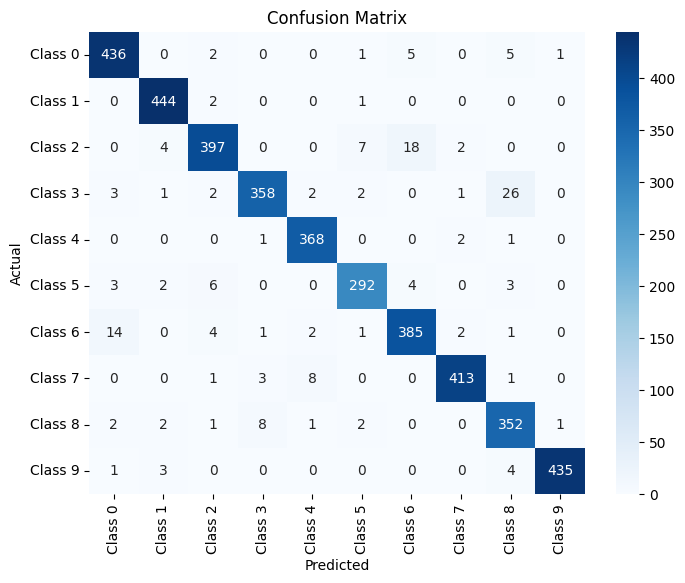

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96       450
     Class 1       0.97      0.99      0.98       447
     Class 2       0.96      0.93      0.94       428
     Class 3       0.96      0.91      0.93       395
     Class 4       0.97      0.99      0.98       372
     Class 5       0.95      0.94      0.95       310
     Class 6       0.93      0.94      0.94       410
     Class 7       0.98      0.97      0.98       426
     Class 8       0.90      0.95      0.92       369
     Class 9       1.00      0.98      0.99       443

    accuracy                           0.96      4050
   macro avg       0.96      0.96      0.96      4050
weighted avg       0.96      0.96      0.96      4050



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 検証データでの推論
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  # val_loader: 検証データのDataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# クラス名とラベルを一致させる
unique_labels = sorted(set(all_labels))  # 出現するクラスラベルを取得
if 'class_names' not in globals() or len(class_names) != len(unique_labels):
    class_names = [f"Class {i}" for i in unique_labels]  # 自動生成（例: "Class 0", "Class 1", ...）

# 混同行列の作成
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1スコアのレポート
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)


In [27]:
torch.save(model.state_dict(), "model.pth")